In [284]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

#### ppl always say NNs cant extrapolate... i just wanna look at that a little myself for some trivial examples

In [319]:
#simplest possible transformer implementation, except seq_len=2

x = torch.linspace(-50,50,100).reshape(100,1,1)
y= x #shud b obvious
#y = (x**2) #half obvious
#y = 3*x**2-4*x**3+5*torch.cos(x) #hard
print(y.shape) 

dataset= torch.utils.data.TensorDataset(x,y)
dataloader= torch.utils.data.DataLoader(dataset,batch_size=16)

torch.Size([100, 1, 1])


In [295]:
class Transformer(nn.Module):
    def __init__(self, hidden_d, input_d,output_d, n_head,num_layers):
        super().__init__()
        self.embed = nn.Linear(input_d,hidden_d)
        transformer_layer = nn.TransformerEncoderLayer( d_model=hidden_d, nhead=n_head , batch_first=True)
        self.transform = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.unembed = nn.Linear(hidden_d,output_d)

    def forward(self, x):
        x= self.embed(x)
        x= self.transform(x)
        x=self.unembed(x)
        return x

In [287]:
my_transformer = Transformer(16,1,1,8,2)
optimizer=torch.optim.Adam(my_transformer.parameters(),lr=5e-4) #, weight_decay=1e-3
loss_fn = torch.nn.MSELoss()

In [288]:
epochs=5000 #thisll take 90 secs
loss_list=[]
my_transformer.train()
for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        preds= my_transformer(x_batch)
        loss = loss_fn(preds,y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    loss_list.append(loss.detach())
        

KeyboardInterrupt: 

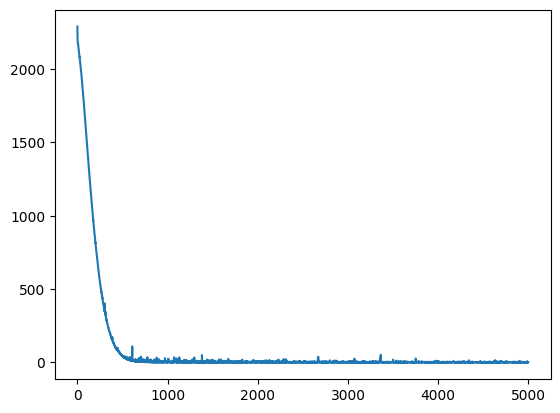

In [ ]:
plt.plot(range(epochs),loss_list)


In [ ]:
x_outside = torch.linspace(-70,70,30).reshape(30,1,1)
my_transformer.eval()
outputs_extrapolation= my_transformer(x_outside)
print(x_outside)

tensor([[[-70.0000]],

        [[-65.1724]],

        [[-60.3448]],

        [[-55.5172]],

        [[-50.6897]],

        [[-45.8621]],

        [[-41.0345]],

        [[-36.2069]],

        [[-31.3793]],

        [[-26.5517]],

        [[-21.7241]],

        [[-16.8966]],

        [[-12.0690]],

        [[ -7.2414]],

        [[ -2.4138]],

        [[  2.4138]],

        [[  7.2414]],

        [[ 12.0690]],

        [[ 16.8966]],

        [[ 21.7241]],

        [[ 26.5517]],

        [[ 31.3793]],

        [[ 36.2069]],

        [[ 41.0345]],

        [[ 45.8621]],

        [[ 50.6897]],

        [[ 55.5172]],

        [[ 60.3448]],

        [[ 65.1724]],

        [[ 70.0000]]])


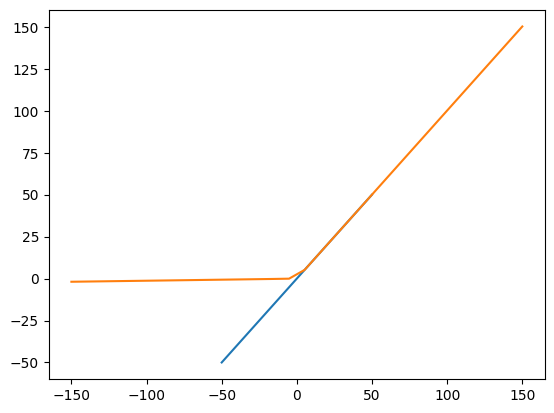

In [333]:
fig=plt.figure()
ax=fig.add_subplot()
ax.plot(x[:,0,0],y[:,0,0])
ax.plot(x_outside[:,0,0], outputs_extrapolation.detach()[:,0,0])

### ok i totally didnt expect this, it doesnt even learn a linear... no matter whether i make d_model 8 or 128... weight decay also didnt change anything, even when absurdly high like .1

### i dont really expect anything different from MLP , in fact shud b very similar result since seq_len=1, but lets just shoot

In [334]:
hidden=2000 #2 to inf all seem to work. do 1000 or whatever for more complicated fn
epochs=500
class myMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(   nn.Linear(1,hidden),nn.ReLU( ),nn.Linear(hidden,1) ) #nn.Sigmoid pretty cool too
        # this does better for y=x**2 self.mlp = nn.Sequential(   nn.Linear(1,hidden),nn.ReLU( ),nn.Linear(hidden,hidden) ,nn.ReLU( ),nn.Linear(hidden,hidden) ,nn.ReLU( ),nn.Linear(hidden,1) )

    def forward(self,data):
        data = self.mlp(data)
        return data

Text(0.5, 1.0, 'loss')

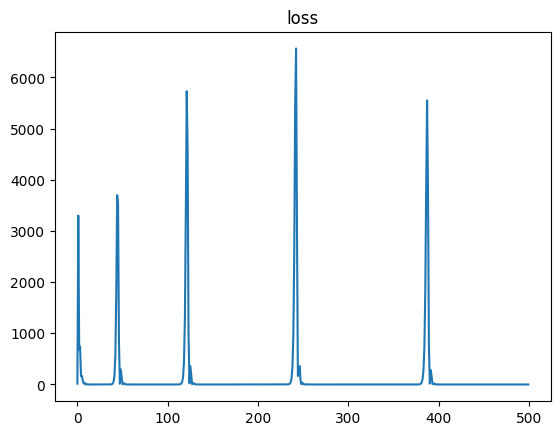

In [335]:
loss_list=[]
myMLP_instance= myMLP()
optimizer=torch.optim.Adam(myMLP_instance.parameters())
myMLP_instance.train()
for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        preds= myMLP_instance(x_batch)
        loss = loss_fn(preds,y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    loss_list.append(loss.detach())
        
plt.plot(range(epochs),loss_list)
plt.title("loss")

Text(0.5, 0.98, 'mlp. this learnt perfectly the line but cant nail the x**2. orange= extrapolation')

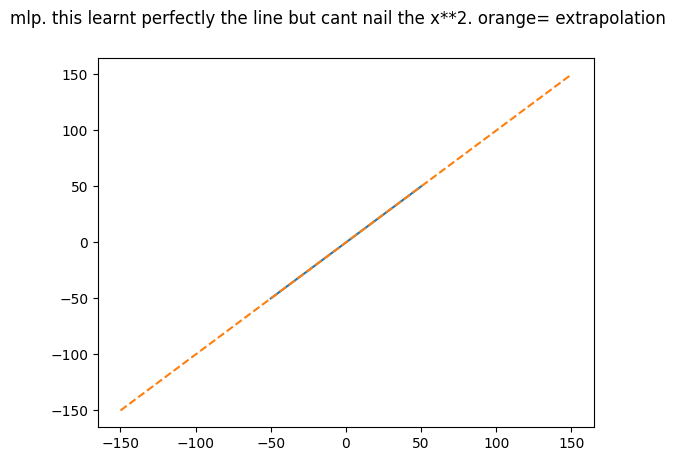

In [336]:
x_outside = torch.linspace(-150,150,30).reshape(30,1,1)
myMLP_instance.eval()
outputs_extrapolation= myMLP_instance(x_outside)
#print(x_outside)

fig=plt.figure()
ax=fig.add_subplot()
ax.plot(x[:,0,0],y[:,0,0], markersize=1000)
ax.plot(x_outside[:,0,0], outputs_extrapolation.detach()[:,0,0], linestyle="dashed" )
fig.suptitle("mlp. this learnt perfectly the line but cant nail the x**2. orange= extrapolation")

Actually it makes sense that MLP works for this function (in fact I look at hidden=2 MLP and the params literally add up the x<0 and x>0 halves of the linear function, and also any extrapolation it does w ReLU will be linear outside the last ReLu kinks) . 

and with nn.Sigmoid, u have this 1/(1+e**(-x)) stuff which means when u extrapolate ur either gonna hit sigmoid ->0 or ->1 so the outputs mlp(x) -> constant... 

In [323]:
print(list(myMLP_instance.parameters()))

[Parameter containing:
tensor([[ 0.3105],
        [ 0.7813],
        [-0.9484],
        ...,
        [ 0.0021],
        [ 0.8172],
        [-0.5354]], requires_grad=True), Parameter containing:
tensor([ 0.9187,  0.1249, -0.5033,  ..., -0.0275, -0.3156, -0.6796],
       requires_grad=True), Parameter containing:
tensor([[ 1.4892e-02, -3.0940e-03,  1.1835e-02,  ...,  9.3795e-05,
          2.1215e-02, -1.8241e-03]], requires_grad=True), Parameter containing:
tensor([-0.0169], requires_grad=True)]


In [300]:
print("so slope in +x",1.0425*0.9358)
print("so slope in +x",-1.2012*(-0.8096))

so slope in +x 0.9755714999999999
so slope in +x 0.97249152


### ok this is all very interesting... might do research on how to make nn's generalize btr... Im super curious: for any complicated function, can NNs extrapolate? I suppose there are many possible functions for any complicated pattern, and are there any tricks that people use to bias the NN toward more accurate such functions? .... tbd later...